In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf  #tsa- time series analysis
from statsmodels.tsa.arima_model import ARIMA,ARMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams   #for entire jupy file, fig size is fixed(using rcParams, we can fix fig size.)
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv("C:/Users/MauryaEtech/Desktop/Simplilearn/Machine learning recordings/ML-time series model/monthly-beer-production-in-austr.csv")

In [3]:
data.head()

,Month,Monthly beer production in Australia
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In [4]:
data.tail()

,Month,Monthly beer production in Australia
471,1995-04,127.0
472,1995-05,151.0
473,1995-06,130.0
474,1995-07,119.0
475,1995-08,153.0


In [5]:
data.shape

(476, 2)

In [6]:
data.describe()

,Monthly beer production in Australia
count,476.000000
mean,136.395378
std,33.738725
min,64.800000
25%,112.900000
50%,139.150000
75%,158.825000
max,217.800000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Month                                 476 non-null    object 
 1   Monthly beer production in Australia  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [8]:
data['Month'].head()

0    1956-01
1    1956-02
2    1956-03
3    1956-04
4    1956-05
Name: Month, dtype: object

In [9]:
data['Month'] = data['Month'].apply(lambda x: dt(int(x[:4]), int(x[5:]), 15))  #15 here, is passing date information, as date isnt given, hence date can be passed as anything.
data = data.set_index('Month')
data.head()

,Monthly beer production in Australia
Month,
1956-01-15,93.2
1956-02-15,96.0
1956-03-15,95.2
1956-04-15,77.1
1956-05-15,70.9


In [10]:
ts = data['Monthly beer production in Australia']

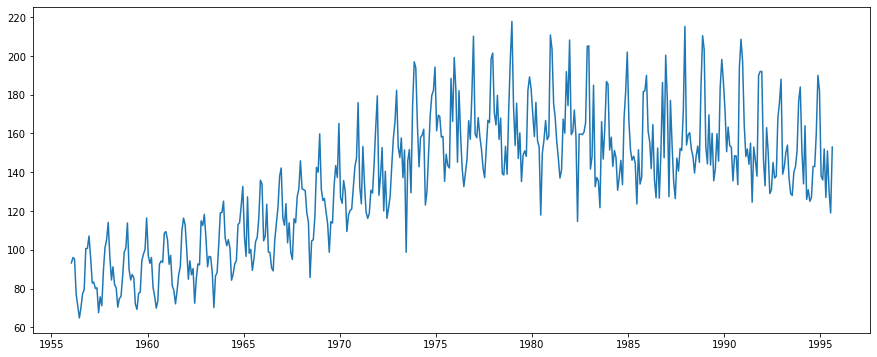

In [11]:
plt.plot(ts)

In [12]:
# 1.1 Observe seasonality and trend in the above graph

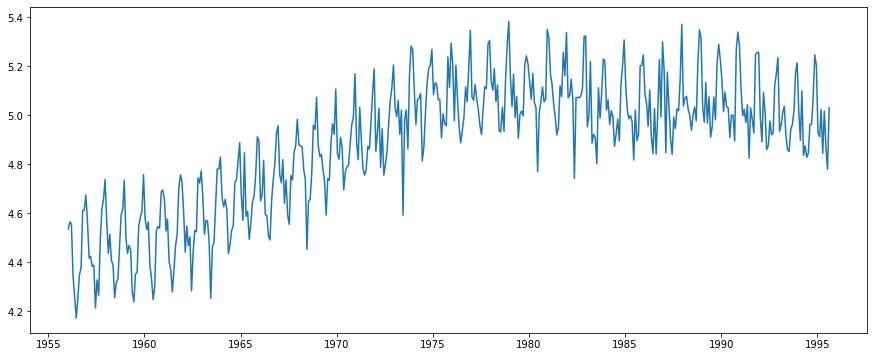

In [13]:
#transformation
ts_log = np.log(ts)
plt.plot(ts_log)

In [14]:
#Techinques used--to analyze whether data is stationary or not.
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean()   #1year=52 weeks, or 1year=12months can be mentioned. (52-1 times the data shifting is done)
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

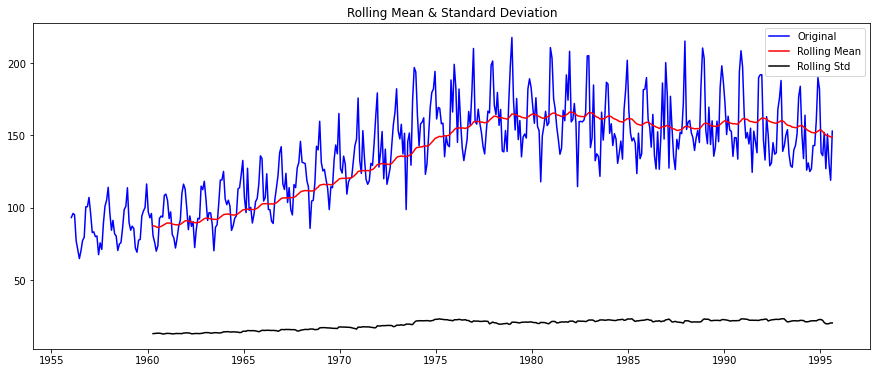

Results of Dickey-Fuller Test:
Test Statistic                  -2.282661
p-value                          0.177621
#Lags Used                      17.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


In [15]:
test_stationarity(data['Monthly beer production in Australia'])

In [16]:
# p-value is >0.05, hence accept null hypothesis. (data is not stationary).Stationary data should be constant, not continuous.
# The time series is not stationary
# conclusion- by using both techniques, the data is not stationary

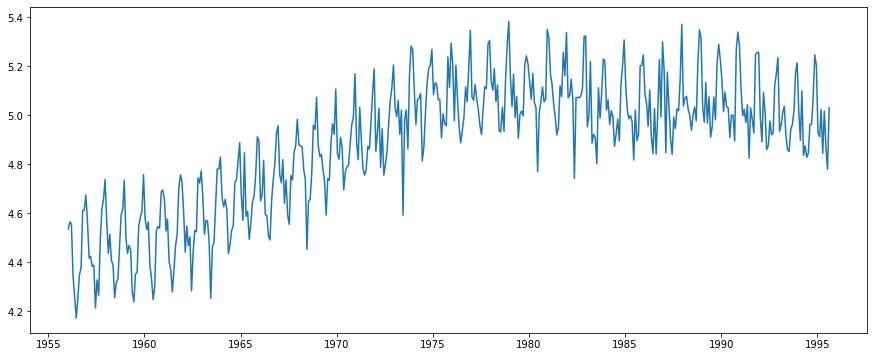

In [17]:
plt.plot(ts_log)

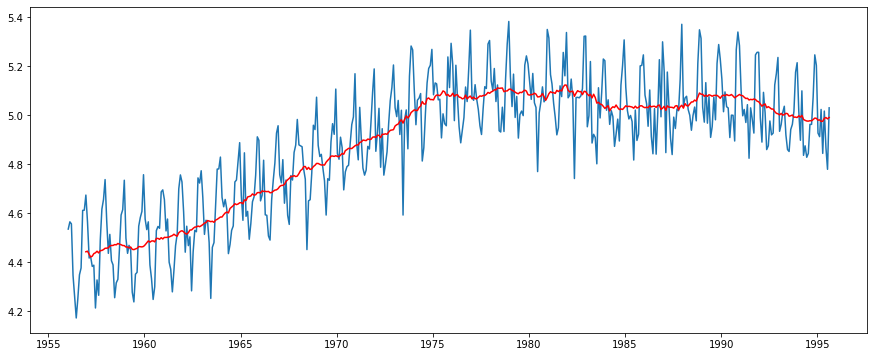

In [18]:
#converting non-stationary data into stationary by applying logarithm on data.
movingAverage = ts_log.rolling(window=12).mean()   # 12-1 = 11 shifts of data
movingSTD = ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(movingAverage, color='red')

In [19]:
# Get the difference between the moving average and the actual number of passengers
ts_log_mv_diff = ts_log - movingAverage
ts_log_mv_diff.head(12)
#Remove Nan Values
ts_log_mv_diff.dropna(inplace=True)
ts_log_mv_diff.head(12)

# why are we shifting data? - to get a stationary data, we shift and drop unneccesary data.

Month
1956-12-15    0.231830
1957-01-15    0.118994
1957-02-15   -0.015558
1957-03-15    0.001590
1957-04-15   -0.041908
1957-05-15   -0.047399
1957-06-15   -0.225688
1957-07-15   -0.117442
1957-08-15   -0.173166
1957-09-15    0.045062
1957-10-15    0.168757
1957-11-15    0.204867
Name: Monthly beer production in Australia, dtype: float64

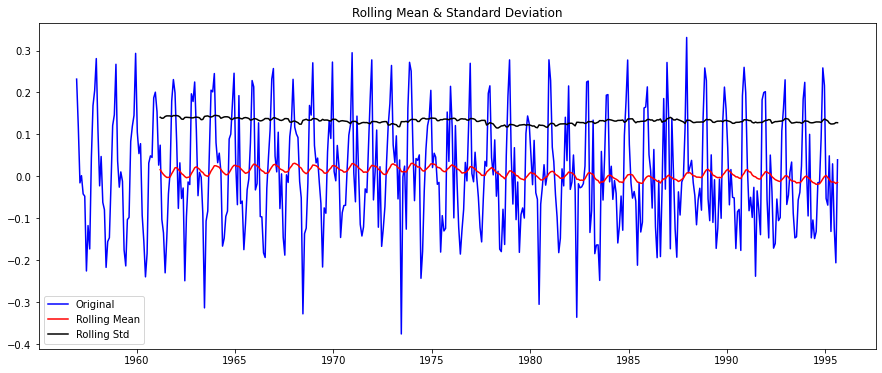

Results of Dickey-Fuller Test:
Test Statistic                  -3.432559
p-value                          0.009898
#Lags Used                      13.000000
Number of Observations Used    451.000000
Critical Value (1%)             -3.444933
Critical Value (5%)             -2.867970
Critical Value (10%)            -2.570195
dtype: float64


In [20]:
test_stationarity(ts_log_mv_diff)  

In [21]:
 # mean and std is constant..,we can say data is stationary.
# p-value is <0.05 (from above).., (reject null, accept alternate).. hence the conclusion is- data is stationary.
# The time series is now stationary.

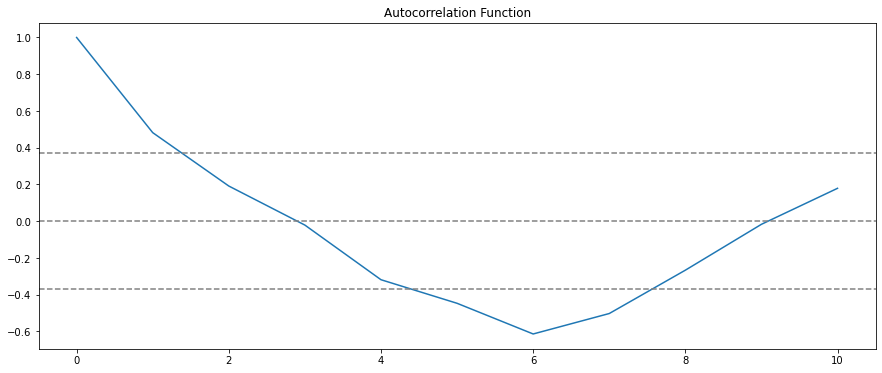

In [22]:
# to find acf, pass the stationary data.. i.e, ts_log_mv_diff
plt.plot(np.arange(0,11), acf(ts_log_mv_diff, nlags = 10))   #x-axis= (0-10), i.e, 10 values, so nlags=10shifts
plt.axhline(y=0,linestyle='--',color='gray')   #axhline-horizontal line..y values are fixed threshold values.
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')  #negative threshold
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')   #positive threshold
plt.title('Autocorrelation Function')
plt.show()

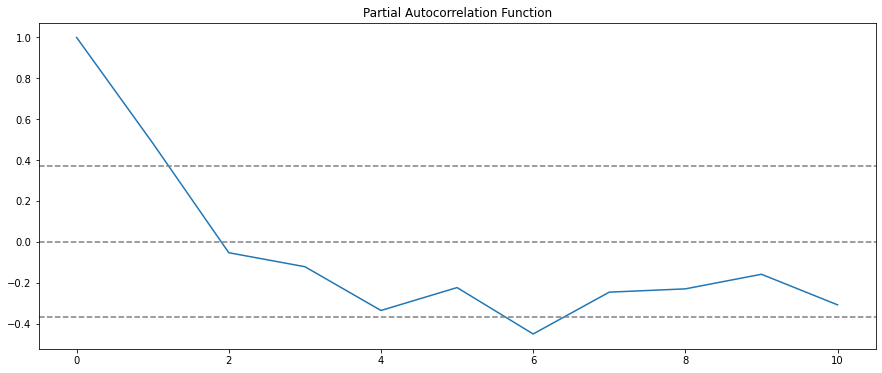

In [23]:
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff, nlags = 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

Text(0.5, 1.0, 'RSS: nan')

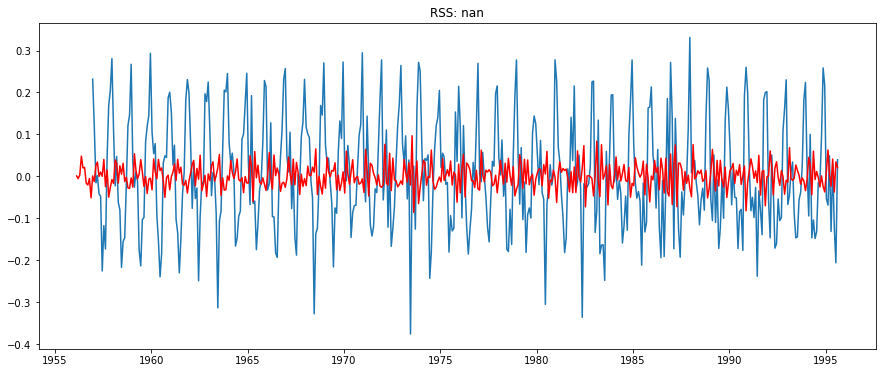

In [24]:
model = ARIMA(ts_log, order=(1, 1, 0))  # (p,d,q) q should be 0 to 1, p should be 1 or 2.
results_ARIMA = model.fit(disp=-1)  #disp--till last data points, till end
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues[1:] - ts_log_mv_diff)**2))

# blue line= original data, and red line is= fitted line.

Text(0.5, 1.0, 'RSS: nan')

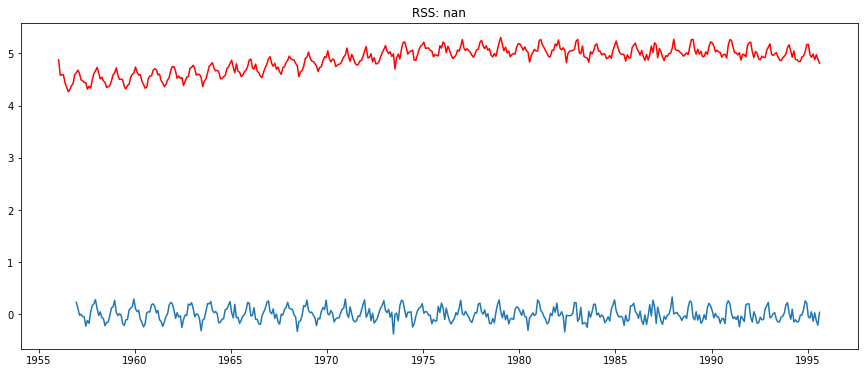

In [25]:
# check ARMA
model = ARMA(ts_log, order=(1, 1, 0))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues[1:] - ts_log_mv_diff)**2))

#in graph, it is a scaled one, but the data information remains same using arma and arima, it never changes.
# for this data, ARMA is suiting better.

Text(0.5, 1.0, 'RSS: nan')

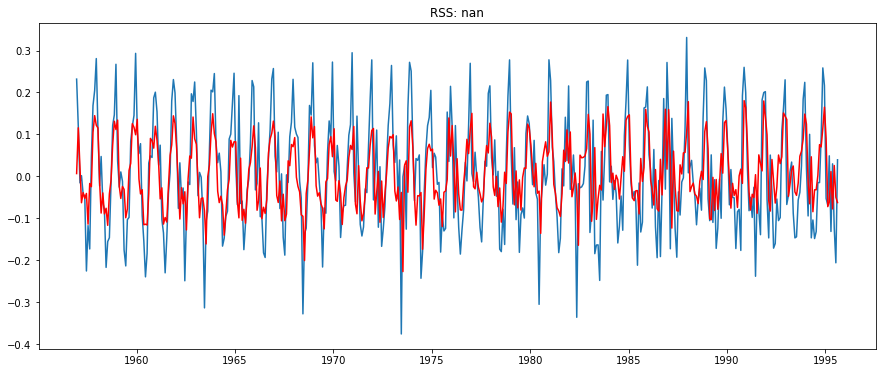

In [26]:
# we can pass the stationary data in ARMA, and check the prediction
model = ARMA(ts_log_mv_diff, order=(2, 1)) # we can pass order(1,1) also.
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues[1:] - ts_log_mv_diff)**2))


In [27]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       ARMA Model Results                                       
================================================================================================
Dep. Variable:     Monthly beer production in Australia   No. Observations:                  465
Model:                                       ARMA(2, 1)   Log Likelihood                 386.673
Method:                                         css-mle   S.D. of innovations              0.105
Date:                                  Sun, 27 Mar 2022   AIC                           -763.345
Time:                                          18:20:36   BIC                           -742.635
Sample:                                               0   HQIC                          -755.194
                                                                                                
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                          0.0066      0.002      2.855      0.004       0.002       0.011
ar.L1.Monthly beer production in Australia     1.3342      0.039     34.334      0.000       1.258       1.410
ar.L2.Monthly beer production in Australia    -0.5981      0.037    -16.054      0.000      -0.671      -0.525
ma.L1.Monthly beer production in Australia    -0.8769      0.019    -46.116      0.000      -0.914      -0.840
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1154           -0.6542j            1.2931           -0.0844
AR.2            1.1154           +0.6542j            1.2931            0.0844
MA.1            1.1404           +0.0000j            1.1404            0.0000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: nan')

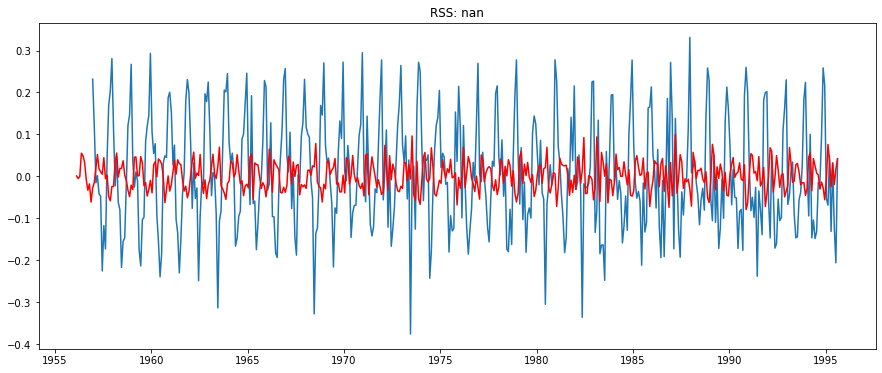

In [28]:
model = ARIMA(ts_log, order=(2,1,0)) 
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues[1:] - ts_log_mv_diff)**2))

In [29]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       ARIMA Model Results                                        
==================================================================================================
Dep. Variable:     D.Monthly beer production in Australia   No. Observations:                  475
Model:                                     ARIMA(2, 1, 0)   Log Likelihood                 289.452
Method:                                           css-mle   S.D. of innovations              0.132
Date:                                    Sun, 27 Mar 2022   AIC                           -570.905
Time:                                            18:21:19   BIC                           -554.251
Sample:                                                 1   HQIC                          -564.356
                                                                                                  
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            0.0009      0.004      0.205      0.837      -0.008       0.010
ar.L1.D.Monthly beer production in Australia    -0.2508      0.046     -5.495      0.000      -0.340      -0.161
ar.L2.D.Monthly beer production in Australia    -0.1249      0.046     -2.740      0.006      -0.214      -0.036
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0036           -2.6453j            2.8293           -0.3077
AR.2           -1.0036           +2.6453j            2.8293            0.3077
-----------------------------------------------------------------------------
"""

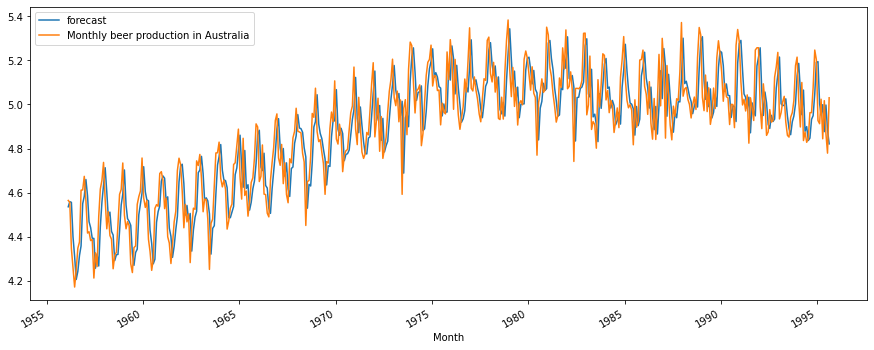

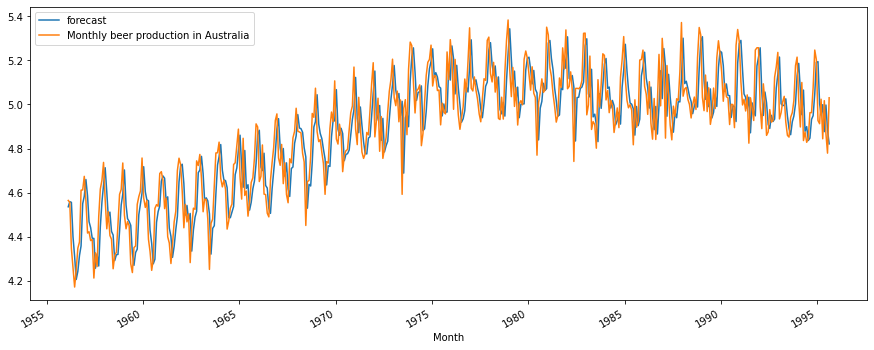

In [30]:
results_ARIMA.plot_predict()

In [33]:
data.shape

(476, 1)

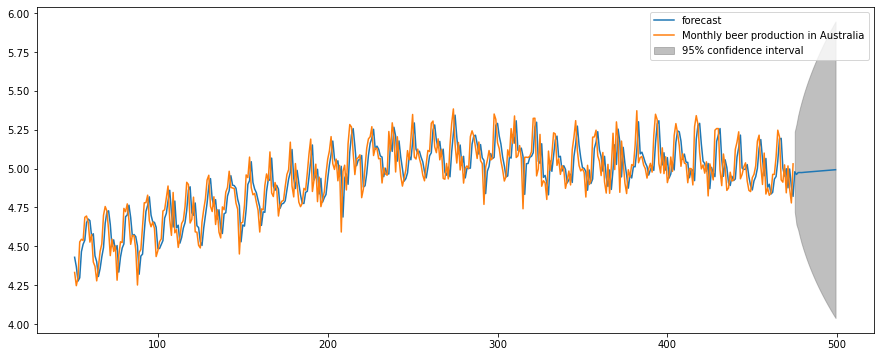

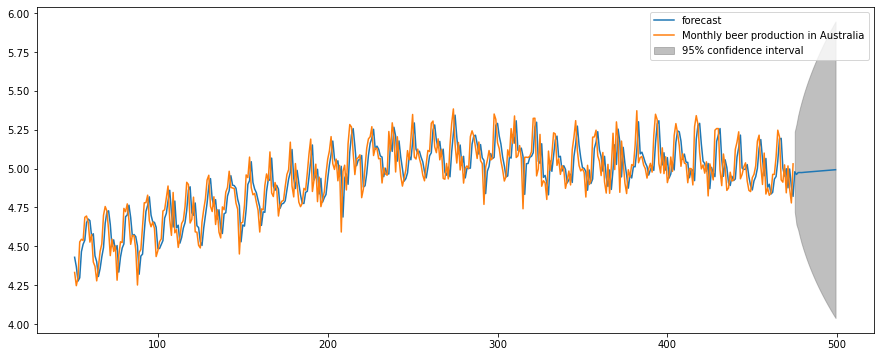

In [35]:
results_ARIMA.plot_predict(start=52,  end=500)

In [36]:
results_ARIMA.forecast()   # here, first array value is the output.

(array([4.97970543]), array([0.131546]), array([[4.72188   , 5.23753085]]))

In [37]:
results_ARIMA.forecast(10)

(array([4.97970543, 4.9622723 , 4.9742222 , 4.97464431, 4.9742864 ,
        4.97556419, 4.97652926, 4.97736841, 4.9782782 , 4.97918601]),
 array([0.131546  , 0.16437306, 0.18759096, 0.21098652, 0.23181626,
        0.25067916, 0.26829918, 0.28483905, 0.300459  , 0.31530781]),
 array([[4.72188   , 5.23753085],
        [4.64010702, 5.28443758],
        [4.60655066, 5.34189373],
        [4.56111834, 5.38817028],
        [4.51993489, 5.42863792],
        [4.48424207, 5.46688631],
        [4.45067253, 5.502386  ],
        [4.41909414, 5.53564269],
        [4.38938939, 5.56716702],
        [4.36119406, 5.59717796]]))

In [38]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1956-02-15    0.000902
1956-03-15   -0.005495
1956-04-15   -0.000359
1956-05-15    0.055164
1956-06-15    0.048606
dtype: float64

In [39]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1956-02-15    0.000902
1956-03-15   -0.004593
1956-04-15   -0.004952
1956-05-15    0.050212
1956-06-15    0.098818
dtype: float64

In [40]:
predictions_ARIMA_log = pd.Series(ts_log[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.unique()

array([4.53474772, 4.53564966, 4.53015449, 4.52979581, 4.58496001,
       4.63356573, 4.66783823, 4.66060426, 4.6275074 , 4.60949728,
       4.54820616, 4.51979125, 4.50545719, 4.52669794, 4.57856759,
       4.5966473 , 4.6072719 , 4.6123117 , 4.6567828 , 4.65112212,
       4.6537602 , 4.60568233, 4.54733047, 4.52309883, 4.4990093 ,
       4.53263424, 4.58813761, 4.58642574, 4.60495646, 4.623957  ,
       4.66096866, 4.66375543, 4.65376202, 4.62097909, 4.57251301,
       4.55145419, 4.51977223, 4.56537586, 4.61175698, 4.61256142,
       4.61436877, 4.66130815, 4.69410939, 4.6719007 , 4.65705659,
       4.61006915, 4.57888105, 4.56936127, 4.52986664, 4.5578451 ,
       4.59255149, 4.59122063, 4.63265063, 4.66998399, 4.69955629,
       4.69847974, 4.63569298, 4.60394998, 4.60492098, 4.56978426,
       4.55036632, 4.56062998, 4.59890215, 4.60392645, 4.6433287 ,
       4.67378905, 4.70184495, 4.69269779, 4.65756673, 4.63405503,
       4.58305568, 4.54707656, 4.54846435, 4.58394757, 4.64179

Text(0.5, 1.0, 'RMSE: 41.0764')

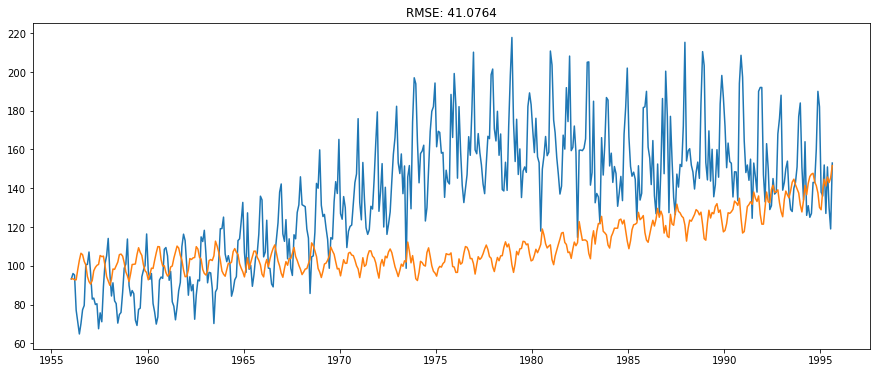

In [41]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)   #logarithmic prediction
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))